## Data preprocessing

In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# reading data from csv files
btc_price = pd.read_csv("bitcoin_price.csv", parse_dates=['Date'])
eth_price = pd.read_csv("ethereum_price.csv", parse_dates=['Date'])
ltc_price = pd.read_csv("litecoin_price.csv", parse_dates=['Date'])

monero_price = pd.read_csv("monero_price.csv", parse_dates=['Date'])

# we need to prune redundant data to create a common shape for all arrays of data
# ethereum is the youngest cryptocurrency, so that we will prune other to its len
# also, we don't need first month of eth data, because it was very unstable
rows_num = len(eth_price) - 30
btc_price = btc_price[:rows_num]
ltc_price = ltc_price[:rows_num]
eth_price = eth_price[:rows_num]
monero_price = monero_price[:rows_num]


# check if some dates are missed or data is corrupted
if (ltc_price['Date'] == btc_price['Date']).all() and \
(btc_price['Date'] == eth_price['Date']).all() and \
(eth_price['Date'] == monero_price['Date']).all():
    print ('All dates are correct.')

All dates are correct.


In [2]:
# ok, now we can drop Date column from tables
btc_price.drop(['Date'], axis=1, inplace=True)
ltc_price.drop(['Date'], axis=1, inplace=True)
eth_price.drop(['Date'], axis=1, inplace=True)
monero_price.drop(['Date'], axis=1, inplace=True)

# last 2 columns was readed like strs because of ',' separator for thousands
btc_price = btc_price.applymap(lambda x: int(x.replace(',', '')) if type(x) is str else x)
eth_price = eth_price.applymap(lambda x: int(x.replace(',', '')) if type(x) is str else x)
ltc_price = ltc_price.applymap(lambda x: int(x.replace(',', '')) if type(x) is str else x)
monero_price = monero_price.applymap(lambda x: int(x.replace(',', '')) if type(x) is str else x)

In [3]:
# The goal is to predict the correlation between the price of top coins and some altcoins.
# Since from the begging of 2015 year all cryptocurrencies have been rising in price,
# there is no sense in taking absolute values, so that we will take changes for every day
eth_dynamic = pd.DataFrame(eth_price.as_matrix()[:-1] / eth_price.as_matrix()[1:], columns=[eth_price.columns])
ltc_dynamic = pd.DataFrame(ltc_price.as_matrix()[:-1] / ltc_price.as_matrix()[1:], columns=[eth_price.columns])
btc_dynamic = pd.DataFrame(btc_price.as_matrix()[:-1] / btc_price.as_matrix()[1:], columns=[eth_price.columns])
monero_dynamic = pd.DataFrame(monero_price.as_matrix()[:-1] / monero_price.as_matrix()[1:], columns=[eth_price.columns])

In [4]:
# some features may be really correlated
# we need to remove them to get rid of redundancy in data.
eth_dynamic.corr()

,Open,High,Low,Close,Volume,Market Cap
Open,1.000000,0.494437,0.545206,0.063288,0.035850,0.999953
High,0.494437,1.000000,0.536570,0.703323,0.430013,0.494816
Low,0.545206,0.536570,1.000000,0.563783,-0.221929,0.544559
Close,0.063288,0.703323,0.563783,1.000000,0.162233,0.063225
Volume,0.035850,0.430013,-0.221929,0.162233,1.000000,0.036705
Market Cap,0.999953,0.494816,0.544559,0.063225,0.036705,1.000000


In [5]:
ltc_dynamic.corr()

,Open,High,Low,Close,Volume,Market Cap
Open,1.000000,0.389821,0.635786,0.046792,0.001977,0.999911
High,0.389821,1.000000,0.449421,0.779069,0.588270,0.390045
Low,0.635786,0.449421,1.000000,0.451471,-0.069247,0.635739
Close,0.046792,0.779069,0.451471,1.000000,0.473834,0.046872
Volume,0.001977,0.588270,-0.069247,0.473834,1.000000,0.002249
Market Cap,0.999911,0.390045,0.635739,0.046872,0.002249,1.000000


In [6]:
btc_dynamic.corr()

,Open,High,Low,Close,Volume,Market Cap
Open,1.000000,0.530896,0.498170,0.023685,0.029856,0.999998
High,0.530896,1.000000,0.506940,0.606576,0.355196,0.530898
Low,0.498170,0.506940,1.000000,0.599725,-0.249762,0.498161
Close,0.023685,0.606576,0.599725,1.000000,0.061991,0.023666
Volume,0.029856,0.355196,-0.249762,0.061991,1.000000,0.029891
Market Cap,0.999998,0.530898,0.498161,0.023666,0.029891,1.000000


In [7]:
# Market cap correlating with Open with coefficient practically equal to 1
# better to delete it
btc_dynamic.drop(['Market Cap'], axis=1, inplace=True)
ltc_dynamic.drop(['Market Cap'], axis=1, inplace=True)
eth_dynamic.drop(['Market Cap'], axis=1, inplace=True)

In [8]:
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

# normalized copies
eth_dynamic_normalized = scaler.fit_transform(eth_dynamic)
btc_dynamic_normalized = scaler.fit_transform(btc_dynamic)
ltc_dynamic_normalized = scaler.fit_transform(ltc_dynamic)
monero_dynamic_normalized = scaler.fit_transform(monero_dynamic)
# We don't need normalising for tree based algorithms
# but it is important for methods like linear regression

X_dynamic_norm = np.concatenate((eth_dynamic_normalized, btc_dynamic_normalized, ltc_dynamic_normalized), axis=1)

# now we need to concatenate data for btc, ltc and eth
X_dynamic = np.concatenate((eth_dynamic, btc_dynamic, ltc_dynamic), axis=1)

# we will take 1 day offset, so that we will predict monero price
# for 1 day into the future
X_train, X_test, y_train, y_test = train_test_split(X_dynamic[1:], monero_dynamic.as_matrix()[:-1,3], test_size=0.2)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_dynamic_norm[1:], monero_dynamic.as_matrix()[:-1,3], test_size=0.2)

## Random forest

In [9]:
predictions, predictions_train = [], []
reg = RandomForestRegressor(n_estimators=100, warm_start=True)

for i in tqdm(range(100, 5100, 50)):
    reg.set_params(n_estimators=i)
    reg.fit(X_train, y_train)
    ans = reg.predict(X_test)
    ans1 = reg.predict(X_train)
    
    predictions.append(mean_absolute_error(y_test, ans))
    predictions_train.append(mean_absolute_error(y_train, ans1))

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


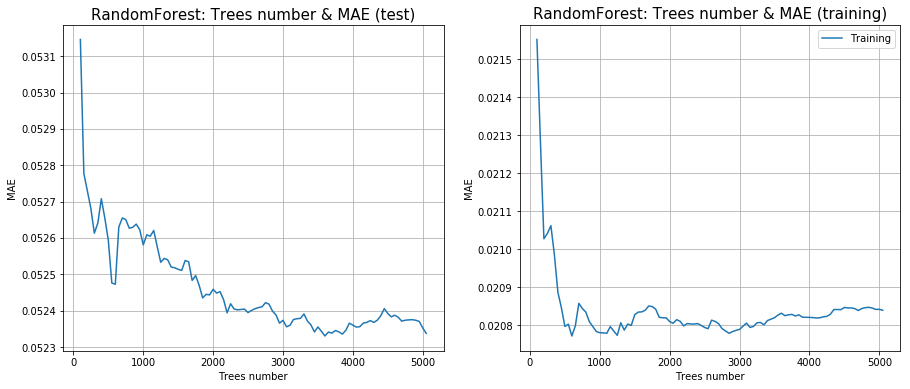

In [10]:
# absolute values are very different so that we will make 2 plots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(100, 5100, 50), predictions, label='Test')
plt.grid()
plt.xlabel('Trees number')
plt.ylabel('MAE')
plt.title('RandomForest: Trees number & MAE (test)', size=15)


plt.subplot(1, 2, 2)
plt.plot(np.arange(100, 5100, 50), predictions_train, label='Training')
plt.grid()
plt.xlabel('Trees number')
plt.ylabel('MAE')
plt.title('RandomForest: Trees number & MAE (training)', size=15)
plt.legend()

plt.show()

It is clearly seen that mae error not decreasing after about 1000 trees
so that there is no point in paying more time for training extra trees.
Now we need to prune our tree in order to avoid overfitting.

In [11]:
results1, results2, results3 = [], [], []

# here we will use fewer number of estimators
# this should not give worse results
for i in tqdm(range(1, 51)):
    reg = RandomForestRegressor(n_estimators=500, max_depth=i, n_jobs=-1)
    reg.fit(X_train, y_train)
    results1.append(mean_absolute_error(y_test, reg.predict(X_test)))

    reg = RandomForestRegressor(n_estimators=500, min_samples_split=i+1, n_jobs=-1)
    reg.fit(X_train, y_train)
    results2.append(mean_absolute_error(y_test, reg.predict(X_test)))
    
    reg = RandomForestRegressor(n_estimators=500, min_samples_leaf=i, n_jobs=-1)
    reg.fit(X_train, y_train)
    results3.append(mean_absolute_error(y_test, reg.predict(X_test)))

100%|██████████| 50/50 [04:17<00:00,  5.16s/it]


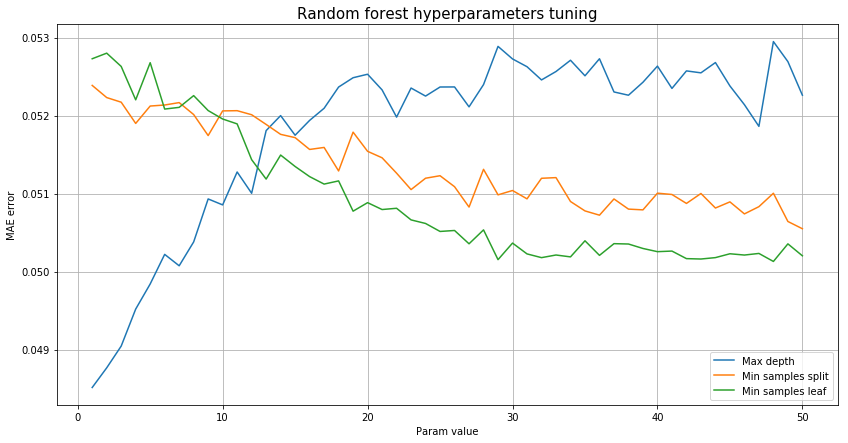

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 51), results1, label='Max depth')
plt.plot(np.arange(1, 51), results2, label='Min samples split')
plt.plot(np.arange(1, 51), results3, label='Min samples leaf')

plt.title('Random forest hyperparameters tuning', size=15)
plt.ylabel('MAE error')
plt.xlabel('Param value')
plt.grid(True)
plt.legend()
plt.show()

Although we can minimize MAE error by taking best params, it is better not to do it, because predictions will become too general.

In [13]:
# best config ca be determined using gridsearch
from sklearn.model_selection import cross_val_score, GridSearchCV

params = {'min_samples_leaf': [1, 5, 10, 15],
         'min_samples_split': [2, 5, 10, 15]}

forest = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
reg = GridSearchCV(forest, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')

reg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 5, 10, 15], 'min_samples_split': [2, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [14]:
best_reg = reg.best_estimator_

In [15]:
# now lets calculte error with our new best config
score = cross_val_score(best_reg,
                X_dynamic[1:], monero_dynamic.as_matrix()[:-1,3],
                cv=5,
                scoring='neg_mean_absolute_error',
                n_jobs=-1).mean()

# also, lets find which of features is the most important
# we need to fit model at first
best_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
print ('Mean absolute error - {}'.format(-1*score))
print ('Feature importances:')
print ('\tEthereum stats:')
for num, i in enumerate(best_reg.feature_importances_[:5]):
    print ('\t\t{} - {}'.format(eth_dynamic.columns[num], i))
print ('\tBitcoin stats:')
for num, i in enumerate(best_reg.feature_importances_[5:10]):
    print ('\t\t{} - {}'.format(eth_dynamic.columns[num], i))
print ('\tLitecoin stats:')
for num, i in enumerate(best_reg.feature_importances_[10:15]):
    print ('\t\t{} - {}'.format(eth_dynamic.columns[num], i))

Mean absolute error - 0.054065803222940564
Feature importances:
	Ethereum stats:
		Open - 0.05298554342958391
		High - 0.05316332315996284
		Low - 0.08700855711843823
		Close - 0.06541437904675283
		Volume - 0.14074782247948084
	Bitcoin stats:
		Open - 0.058557912772392855
		High - 0.047002889019178186
		Low - 0.05827081596932894
		Close - 0.050476420085835215
		Volume - 0.06753629154926256
	Litecoin stats:
		Open - 0.07780269684264045
		High - 0.06916066295842825
		Low - 0.0402078044273948
		Close - 0.07719832155077394
		Volume - 0.054466559590546186


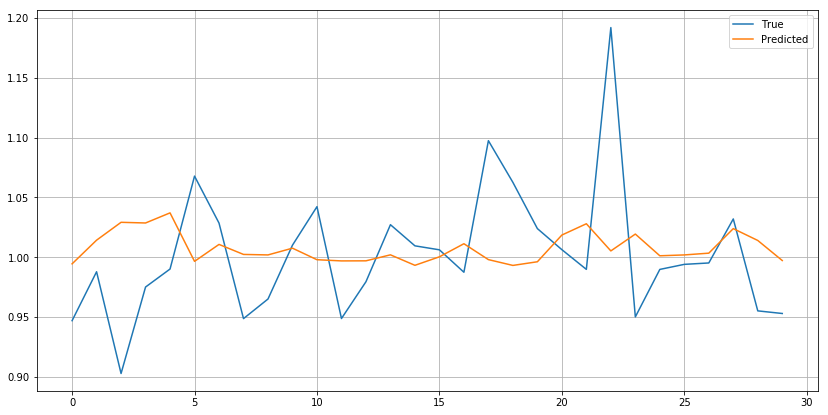

In [17]:
# However, It's hard to interpret results only with error,
# so that lets visualize results.
# We will take real behavior of monero price(close column) during one month
# and behavior, that our model predict
res = best_reg.predict(X_test[:30])
true = y_test[:30]

plt.figure(figsize=(14, 7))
plt.plot(true, label='True')
plt.plot(res, label='Predicted')

# plt.title('Random forest hyperparameters tuning', size=15)
# plt.ylabel('MAE error')
# plt.xlabel('Param value')
plt.grid(True)
plt.legend()
plt.show()

Although prediction is not very precise, we can predict the behavior of price in many cases, what is more than enough.

## Gradient boosting

In [18]:
# we will now try one more ensemble method
from xgboost.sklearn import XGBRegressor

# gradient boosting require complex setup, so we will do it step by step
params1 = {
    'n_estimators' : np.arange(30, 151, 20),
    'learning_rate' : np.linspace(0.1, 0.4, 2)
}

# объявим некоторый набор изначальных средних параметров
xgb = XGBRegressor(
    max_depth = 30,
    subsample = 0.8,
    colsample_bytree = 0.8,
    gamma=0,
    scale_pos_weight=1,
    n_jobs=4
)

# xgb.fit(X_train, y_train)
gbreg = GridSearchCV(xgb, param_grid=params1)
gbreg.fit(X_train, y_train)

xgb.set_params(**gbreg.best_params_)
print ('Best value for n_estimators - {}'.format(gbreg.best_params_['n_estimators']))
print ('Best value for learning rate - {}'.format(gbreg.best_params_['learning_rate']))

Best value for n_estimators - 70
Best value for learning rate - 0.1


In [19]:
params3 = {
    'max_depth' : np.arange(3,50),
    'min_child_weight' : np.arange(1,8)
}

gbreg = GridSearchCV(xgb, param_grid=params3)
gbreg.fit(X_train, y_train)

xgb.set_params(**gbreg.best_params_)
print ('Best value for max_depth - {}'.format(gbreg.best_params_['max_depth']))
print ('Best value for min_child_weight - {}'.format(gbreg.best_params_['min_child_weight']))

Best value for max_depth - 3
Best value for min_child_weight - 5


In [20]:
params4 = {
    'gamma' : np.linspace(0, 0.4, 9)
}

gbreg = GridSearchCV(xgb, param_grid=params4)
gbreg.fit(X_train, y_train)

# снова установим новые значения
xgb.set_params(**gbreg.best_params_)

print ('Best value for gamma - {}'.format(gbreg.best_params_['gamma']))

Best value for gamma - 0.15000000000000002


In [21]:
params5 = {
    'subsample' : np.linspace(0.5, 0.9, 7),
    'colsample_bytree' : np.linspace(0.5, 0.9, 7)
}

gbreg = GridSearchCV(xgb, param_grid=params5)
gbreg.fit(X_train, y_train)


# снова установим новые значения
xgb.set_params(**gbreg.best_params_)

print ('Best value for subsample - {}'.format(gbreg.best_params_['subsample']))
print ('Best value for colsample_bytree - {}'.format(gbreg.best_params_['colsample_bytree']))

Best value for subsample - 0.8333333333333333
Best value for colsample_bytree - 0.8333333333333333


In [22]:
params6 = {
    'reg_alpha' : np.logspace(-5, 2, 10)
}

gbreg = GridSearchCV(xgb, param_grid=params6)
gbreg.fit(X_train, y_train)

# снова установим новые значения
xgb.set_params(**gbreg.best_params_)

print ('Best value for reg_alpha - {}'.format(gbreg.best_params_['reg_alpha']))

Best value for reg_alpha - 1e-05


In [23]:
# Now when we set all params, we can decrease learning rate and proportionally increase n_estimators
xgb.set_params(**{'n_estimators':1000, 'learning_rate':0.01})

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8333333333333333, gamma=0.15000000000000002,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8333333333333333)

In [24]:
score = cross_val_score(xgb,
                X_dynamic[1:], monero_dynamic.as_matrix()[:-1,3],
                cv=5,
                scoring='neg_mean_absolute_error').mean()

print ('Mean absolute error - {}'.format(-1*score))
print ('Feature importances:')
print ('\tEthereum stats:')
for num, i in enumerate(xgb.feature_importances_[:6]):
    print ('\t\t{} - {}'.format(eth_price.columns[num], i))
print ('\tBitcoin stats:')
for num, i in enumerate(xgb.feature_importances_[6:12]):
    print ('\t\t{} - {}'.format(eth_price.columns[num], i))
print ('\tLitecoin stats:')
for num, i in enumerate(xgb.feature_importances_[12:18]):
    print ('\t\t{} - {}'.format(eth_price.columns[num], i))

Mean absolute error - 0.052833163356440484
Feature importances:
	Ethereum stats:
		Open - 0.0
		High - 0.0
		Low - 0.1034482792019844
		Close - 0.0
		Volume - 0.2689655125141144
		Market Cap - 0.09655172377824783
	Bitcoin stats:
		Open - 0.0
		High - 0.04827586188912392
		Low - 0.013793103396892548
		Close - 0.04137931019067764
		Volume - 0.006896551698446274
		Market Cap - 0.006896551698446274
	Litecoin stats:
		Open - 0.013793103396892548
		High - 0.35862070322036743
		Low - 0.04137931019067764


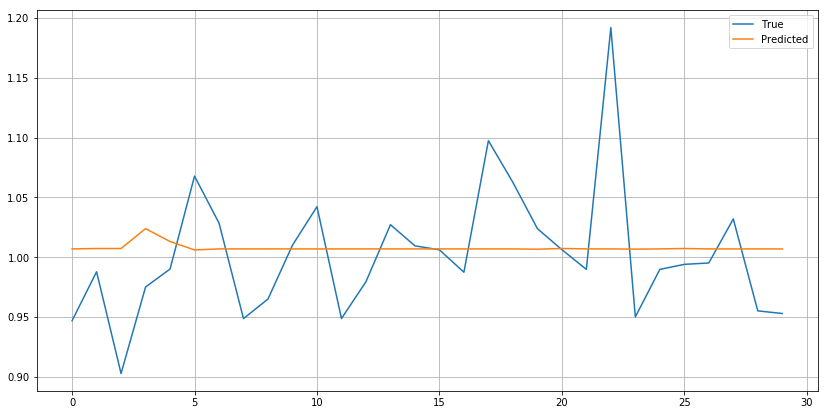

In [25]:
# However, It's hard to interpret results only with error,
# so that lets visualize results.
# We will take real behavior of monero price(close column) during one month
# and behavior, that our model predict
res = xgb.predict(X_test[:30])
true = y_test[:30]

plt.figure(figsize=(14, 7))
plt.plot(true, label='True')
plt.plot(res, label='Predicted')

# plt.title('Random forest hyperparameters tuning', size=15)
# plt.ylabel('MAE error')
# plt.xlabel('Param value')
plt.grid(True)
plt.legend()
plt.show()

Although we got slight decrease in error, in fact model gives us practically constant answer.

## Linear regression

In [26]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_n, y_train_n)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# now lets calculte error with our new best config
score = cross_val_score(linreg,
                X_dynamic_norm[1:], monero_dynamic.as_matrix()[:-1,3],
                cv=5,
                scoring='neg_mean_absolute_error',
                n_jobs=-1).mean()

print ('Mean absolute error: {}'.format(score))

Mean absolute error: -0.05370419779033606


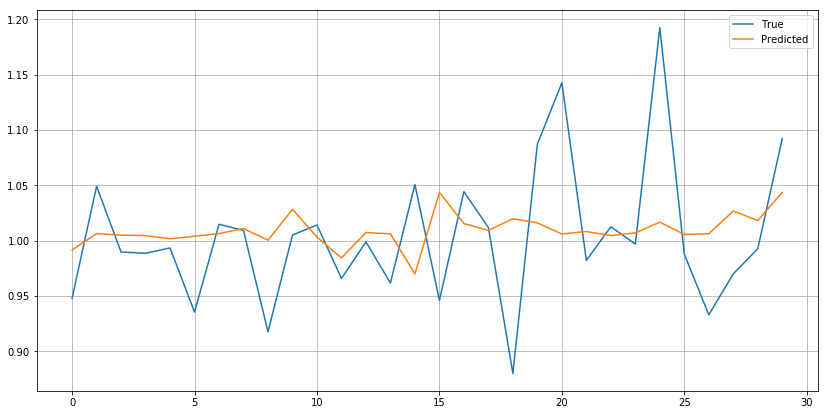

In [28]:
res = linreg.predict(X_test_n[:30])
true = y_test_n[:30]

plt.figure(figsize=(14, 7))
plt.plot(true, label='True')
plt.plot(res, label='Predicted')

# plt.title('Random forest hyperparameters tuning', size=15)
# plt.ylabel('MAE error')
# plt.xlabel('Param value')
plt.grid(True)
plt.legend()
plt.show()

Linear regression has practically same results, but it is fitting much faster and does not require much time for configuration e.g prunning trees.